In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statistics import mean
from scipy import stats

from ast import literal_eval

In [ ]:
def nunique_percent(data: pd.DataFrame) -> pd.Series:
    uniques = data.nunique()
    for i, count in uniques.items():
        percentage = count / data.shape[0] * 100
        print(f'{i}, {count}, {percentage:.2f}%')

def dataframe_info(data: pd.DataFrame) -> None:
    print(data.info())
    print()

    print("NA values per column:")
    print(data.isna().sum())
    print()

    print("Unique values per column:")
    print(nunique_percent(data))
    print()

    print(f'Duplicated Rows: {len(data[data.duplicated()])}')

def safe_convert_to_list(x):
    """Safely convert string representations to lists, trimming spaces."""
    if isinstance(x, str):
        x = x.strip()
        try:
            lst = literal_eval(x)
            return [item.strip() if isinstance(item, str) else item for item in lst]
        except (ValueError, SyntaxError):
            return [item.strip() for item in x.split(',') if item.strip()]
    elif pd.isna(x):
        return []
    return x

def binarize_column(data: pd.DataFrame, col: str):
    mlb = MultiLabelBinarizer()
    data[col] = data[col].apply(safe_convert_to_list)
    binarized_data = mlb.fit_transform(data[col])
    binarized_df = pd.DataFrame(binarized_data, columns=mlb.classes_, index=data.index)

    # Drop original columns
    data = data.drop(col, axis=1)
    data = pd.concat([data, binarized_df], axis=1)

    return data, mlb

def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return dataframe without outliers
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

def remove_outliers_zscore(df, column_name, threshold=3):
    z_scores = stats.zscore(df[column_name])
    return df[abs(z_scores) < threshold]

In [ ]:
df_base_games = pd.read_csv(
    "./info_base_games.csv",
    dtype={"name": "string"},
    converters={
        "appid": lambda x: pd.to_numeric(x, errors="coerce"),
        # 'metacritic': lambda x: pd.to_numeric(x, errors="coerce"),
        "achievements_total": lambda x: pd.to_numeric(x, errors="coerce"),
        "release_date": lambda x: pd.to_datetime(x, errors="coerce"),
    },
)

df_base_games['appid'] = df_base_games['appid'].astype('Int64')
# df_base_games['metacritic'] = df_base_games['metacritic'].astype('Int64')
df_base_games['achievements_total'] = df_base_games['achievements_total'].astype('Int64')

dataframe_info(df_base_games)

<ipython-input-6-65d4abf58e86>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_base_games = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99167 entries, 0 to 99166
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   appid                99166 non-null  Int64         
 1   name                 99149 non-null  string        
 2   metacritic           3019 non-null   object        
 3   steam_achievements   99167 non-null  bool          
 4   steam_trading_cards  99167 non-null  bool          
 5   workshop_support     99167 non-null  bool          
 6   genres               94389 non-null  object        
 7   achievements_total   38114 non-null  Int64         
 8   release_date         78096 non-null  datetime64[ns]
 9   supported_platforms  99167 non-null  object        
dtypes: Int64(2), bool(3), datetime64[ns](1), object(3), string(1)
memory usage: 5.8+ MB
None

NA values per column:
appid                      1
name                      18
metacritic             96148
ste

In [ ]:
df_game_analytics = pd.read_csv(
    "./gamalytic_steam_games.csv",
    dtype={"publisherClass": "string"},
)

dataframe_info(df_game_analytics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93338 entries, 0 to 93337
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   steamId         93338 non-null  int64  
 1   price           93338 non-null  float64
 2   copiesSold      93338 non-null  int64  
 3   publisherClass  93338 non-null  string 
 4   reviewScore     93338 non-null  int64  
 5   aiContent       0 non-null      float64
dtypes: float64(2), int64(3), string(1)
memory usage: 4.3 MB
None

NA values per column:
steamId               0
price                 0
copiesSold            0
publisherClass        0
reviewScore           0
aiContent         93338
dtype: int64

Unique values per column:
steamId, 93338, 100.00%
price, 350, 0.37%
copiesSold, 22474, 24.08%
publisherClass, 4, 0.00%
reviewScore, 99, 0.11%
aiContent, 0, 0.00%
None

Duplicated Rows: 0


In [ ]:
df_dlcs = pd.read_csv(
    "./dlcs.csv",
    dtype={"name": "string"},
    converters={
        "base_appid": lambda x: pd.to_numeric(x, errors="coerce"),
        "dlc_appid": lambda x: pd.to_numeric(x, errors="coerce"),
    },
)

df_dlcs['base_appid'] = df_dlcs['base_appid'].astype('Int64')
df_dlcs['dlc_appid'] = df_dlcs['dlc_appid'].astype('Int64')

dataframe_info(df_dlcs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5445 entries, 0 to 5444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   base_appid  5444 non-null   Int64 
 1   dlc_appid   5444 non-null   Int64 
 2   name        5445 non-null   string
dtypes: Int64(2), string(1)
memory usage: 138.4 KB
None

NA values per column:
base_appid    1
dlc_appid     1
name          0
dtype: int64

Unique values per column:
base_appid, 5444, 99.98%
dlc_appid, 5444, 99.98%
name, 5443, 99.96%
None

Duplicated Rows: 0


In [ ]:
df_demos = pd.read_csv(
    "./demos.csv",
    dtype={"name": "string"},
    converters={
        "full_game_appid": lambda x: pd.to_numeric(x, errors="coerce"),
        "demo_appid": lambda x: pd.to_numeric(x, errors="coerce"),
    },
)

dataframe_info(df_demos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15449 entries, 0 to 15448
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       15449 non-null  int64  
 1   full_game_appid  15448 non-null  float64
 2   demo_appid       15448 non-null  float64
 3   name             15448 non-null  string 
dtypes: float64(2), int64(1), string(1)
memory usage: 482.9 KB
None

NA values per column:
Unnamed: 0         0
full_game_appid    1
demo_appid         1
name               1
dtype: int64

Unique values per column:
Unnamed: 0, 15449, 100.00%
full_game_appid, 15448, 99.99%
demo_appid, 15448, 99.99%
name, 15425, 99.84%
None

Duplicated Rows: 0


In [ ]:
df = df_game_analytics

# Add demos column
df["demo"] = df["steamId"].isin(df_demos["full_game_appid"])

# Add dlc columns
dlc_counts = df_dlcs.groupby("base_appid").size().reset_index(name="dlc_count")

# Merge tables
df = df.merge(dlc_counts, left_on="steamId", right_on="base_appid", how="left")
df = df.merge(df_base_games, left_on="steamId", right_on="appid", how="inner")

dataframe_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69428 entries, 0 to 69427
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   steamId              69428 non-null  int64         
 1   price                69428 non-null  float64       
 2   copiesSold           69428 non-null  int64         
 3   publisherClass       69428 non-null  string        
 4   reviewScore          69428 non-null  int64         
 5   aiContent            0 non-null      float64       
 6   demo                 69428 non-null  bool          
 7   base_appid           3831 non-null   Int64         
 8   dlc_count            3831 non-null   float64       
 9   appid                69428 non-null  Int64         
 10  name                 69428 non-null  string        
 11  metacritic           2933 non-null   object        
 12  steam_achievements   69428 non-null  bool          
 13  steam_trading_cards  69428 non-

In [ ]:
# Fill missing values
df["dlc_count"] = df["dlc_count"].fillna(0).astype(int)
df["achievements_total"] = df["achievements_total"].fillna(0).astype(int)
df["genres"] = df["genres"].fillna("Unknown").astype(str)
df["demo"] = df["demo"].fillna(0).astype(bool)

In [ ]:
df.describe()

,steamId,price,copiesSold,reviewScore,aiContent,base_appid,dlc_count,appid,achievements_total,release_date
count,6.942800e+04,69428.000000,6.942800e+04,69428.000000,0.0,3831.0,69428.000000,69428.0,69428.000000,68279
mean,1.742130e+06,7.940826,8.584933e+04,71.903843,NaN,1376808.242495,0.055179,1742130.059745,21.229187,2021-06-04 08:15:02.649423616
min,1.000000e+01,0.000000,0.000000e+00,0.000000,NaN,2810.0,0.000000,10.0,0.000000,1997-06-30 00:00:00
25%,9.626250e+05,0.990000,6.000000e+01,60.000000,NaN,771725.0,0.000000,962625.0,0.000000,2019-05-22 00:00:00
50%,1.612815e+06,4.990000,4.570000e+02,80.000000,NaN,1150440.0,0.000000,1612815.0,3.000000,2021-11-23 00:00:00
75%,2.581562e+06,9.990000,3.955000e+03,94.000000,NaN,1812320.0,0.000000,2581562.5,20.000000,2024-02-26 00:00:00
max,3.515040e+06,1900.000000,3.021580e+08,100.000000,NaN,3460800.0,1.000000,3515040.0,5394.000000,2025-10-15 00:00:00
std,9.273455e+05,15.533680,1.820168e+06,28.682102,NaN,802800.684535,0.228332,927345.450586,176.403615,NaN


In [ ]:
# Remove outliers

df = remove_outliers_iqr(df, 'copiesSold')
# df = remove_outliers_zscore(df, 'copiesSold')

In [ ]:
df.dropna(
    subset=["release_date"],
    inplace=True,
)

df.drop_duplicates(inplace=True)

# Drop irrelevant columns
X, y = (
    df.drop(
        columns=[
            # IDs
            "appid",
            "base_appid",
            "steamId",

            # Useless, Empty, or Zero-variation
            "name",
            "aiContent",
            "metacritic",

            # Target
            "copiesSold",
        ],
        axis=1,
    ),

    # Scale target variable
    df['copiesSold'],
)

<ipython-input-14-89e334f53009>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(


In [ ]:
# Feature Encoding
X_transformed = X.copy()

X_transformed['release_date'] = (pd.to_datetime('today') - X_transformed['release_date']).dt.days
# X_transformed["release_date"] = X_transformed["release_date"].clip(lower=0)

X_transformed, encoder_genres = binarize_column(X_transformed, "genres")
X_transformed, encoder_supported_platforms = binarize_column(X_transformed, "supported_platforms")

encoder_publisher_class = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder_publisher_class.fit_transform(X_transformed[["publisherClass"]])
onehot_df = pd.DataFrame(
    onehot_encoded,
    columns=encoder_publisher_class.get_feature_names_out(["publisherClass"]),
    index=X_transformed.index
)

X_transformed = X_transformed.drop("publisherClass", axis=1)
X_transformed = pd.concat([X_transformed, onehot_df], axis=1)

In [ ]:
X_transformed.describe()

,price,reviewScore,dlc_count,achievements_total,release_date,Accounting,Action,Adventure,Animation & Modeling,Audio Production,...,Video Production,Violent,Web Publishing,linux,mac,windows,publisherClass_AA,publisherClass_AAA,publisherClass_Hobbyist,publisherClass_Indie
count,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,...,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000,56339.000000
mean,7.026114,70.202453,0.041020,17.000870,1278.599514,0.000053,0.408811,0.398516,0.000142,0.000071,...,0.000035,0.004863,0.000035,0.198921,0.239568,0.999858,0.008023,0.000799,0.659827,0.331351
std,16.003758,30.415498,0.198337,159.771747,977.143511,0.007297,0.491619,0.489597,0.011916,0.008426,...,0.005958,0.069569,0.005958,0.399192,0.426823,0.011916,0.089211,0.028251,0.473771,0.470703
min,0.000000,0.000000,0.000000,0.000000,-151.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.990000,56.000000,0.000000,0.000000,404.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.990000,80.000000,0.000000,0.000000,1178.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,9.990000,95.000000,0.000000,16.000000,2025.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1900.000000,100.000000,1.000000,5394.000000,7991.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
dataframe_info(X_transformed)

<class 'pandas.core.frame.DataFrame'>
Index: 56339 entries, 11988 to 69427
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    56339 non-null  float64
 1   reviewScore              56339 non-null  int64  
 2   demo                     56339 non-null  bool   
 3   dlc_count                56339 non-null  int64  
 4   steam_achievements       56339 non-null  bool   
 5   steam_trading_cards      56339 non-null  bool   
 6   workshop_support         56339 non-null  bool   
 7   achievements_total       56339 non-null  int64  
 8   release_date             56339 non-null  int64  
 9   Accounting               56339 non-null  int64  
 10  Action                   56339 non-null  int64  
 11  Adventure                56339 non-null  int64  
 12  Animation & Modeling     56339 non-null  int64  
 13  Audio Production         56339 non-null  int64  
 14  Casual                 

In [ ]:
# Split into initial train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, shuffle=True, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
numeric_features = [
    "release_date",
    "achievements_total",
    "reviewScore",
    "price",
    # "dlc_count",
]

log_features = [
    "release_date",
    "achievements_total",
    "price",
]

col_scale = ColumnTransformer(
    transformers=[
        # ('log', FunctionTransformer(np.log1p), log_features),
        ("num", StandardScaler(), numeric_features),
    ],
    remainder="passthrough",
)

fs = SelectKBest(score_func=f_regression, k=10)

pipelines = [
    (
        "Linear Regression",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                ("linear", LinearRegression()),
            ],
        ),
    ),
    (
        "Ridge",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                (
                    "ridge",
                    Ridge(
                        # alpha=10.0,
                    ),
                ),
            ],
        ),
    ),
    (
        "Random Forest",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                (
                    "rand_forest",
                    RandomForestRegressor(
                        random_state=42,
                    ),
                ),
            ],
        ),
    ),
    (
        "Gradient Boosting",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                (
                    "gradient_boost",
                    GradientBoostingRegressor(
                        random_state=42,
                    ),
                ),
            ],
        ),
    ),
    (
        "Polynomial Regression (Deg: 2)",
        Pipeline(
            steps=[
                ("scale", col_scale),
                ("feature selecting", fs),
                ("poly_features", PolynomialFeatures(degree=2)),
                ("linear", LinearRegression()),
            ]
        ),
    ),
]

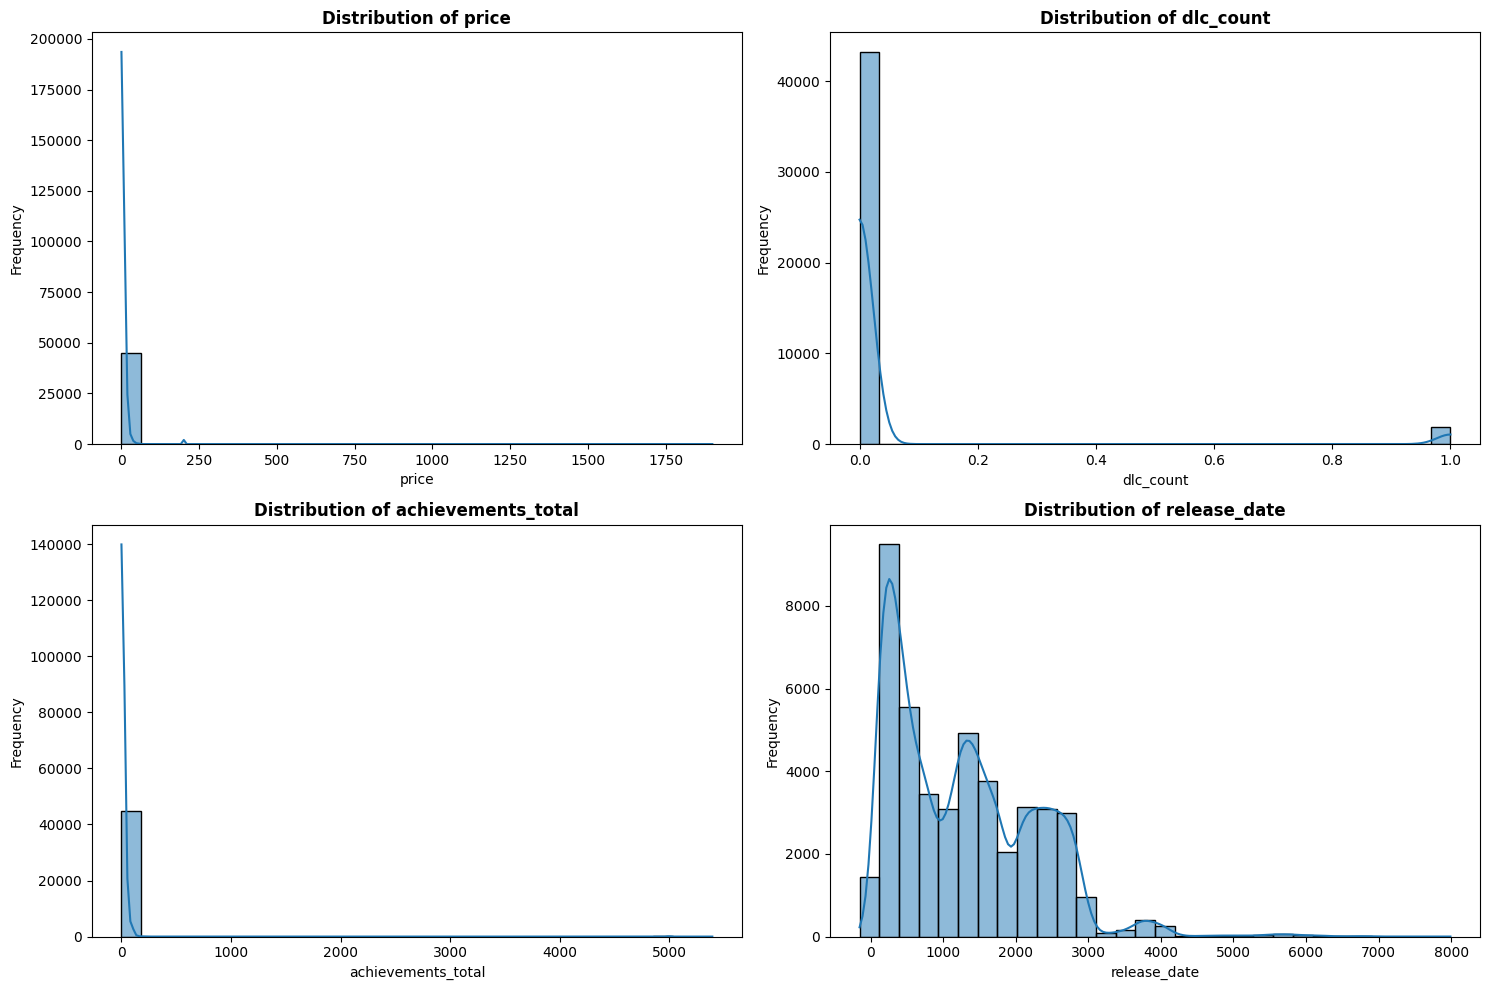

In [ ]:
numeric_features = ['price', 'dlc_count', 'achievements_total', 'release_date']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(X_train[col], bins=30, kde=True, color='#1f77b4', edgecolor='black')
    plt.title(f'Distribution of {col}', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
param_grids = {
    "Linear Regression": {
        'feature selecting__k': [5, 10, 15],
        'linear__fit_intercept': [True, False],
        'linear__positive': [True, False]
    },
}

tuned_pipeline = []
for model_name, pipeline in pipelines:
    if param_grids.get(model_name) is None:
        tuned_pipeline.append((model_name, pipeline));
        continue

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        cv=cv,
        scoring='r2',
        n_jobs=-1,
    )

    tuned_pipeline.append((model_name, grid_search));

Linear Regression Train Time: 17.40 sec
Linear Regression Test Time: 0.05 sec

Linear Regression Test MSE: 2685675.602 (2.685676e+06)
Linear Regression Test R2 : 0.30101588300694904
Linear Regression Best Params: {'feature selecting__k': 15, 'linear__fit_intercept': True, 'linear__positive': False}



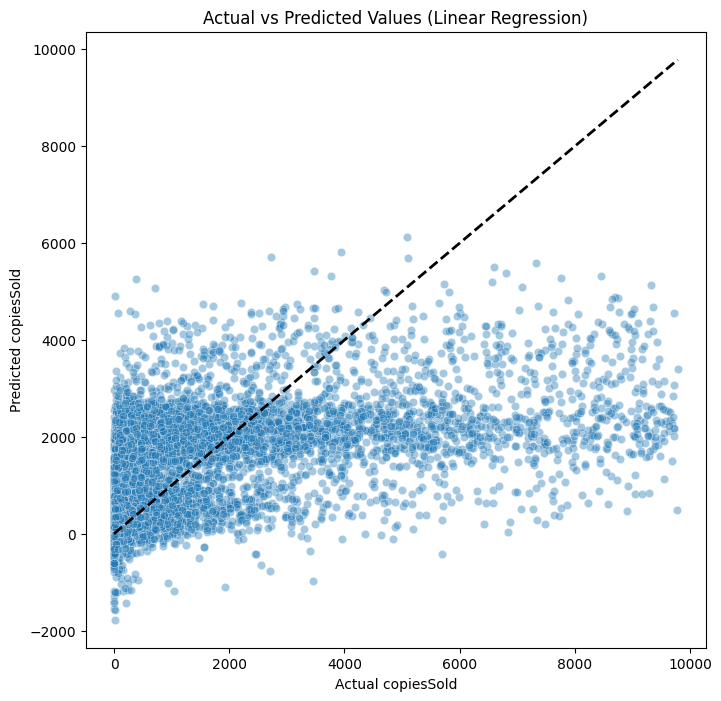

Ridge Train Time: 0.27 sec
Ridge Test Time: 0.03 sec

Ridge Test MSE: 2780282.390 (2.780282e+06)
Ridge Test R2 : 0.2763931616882769



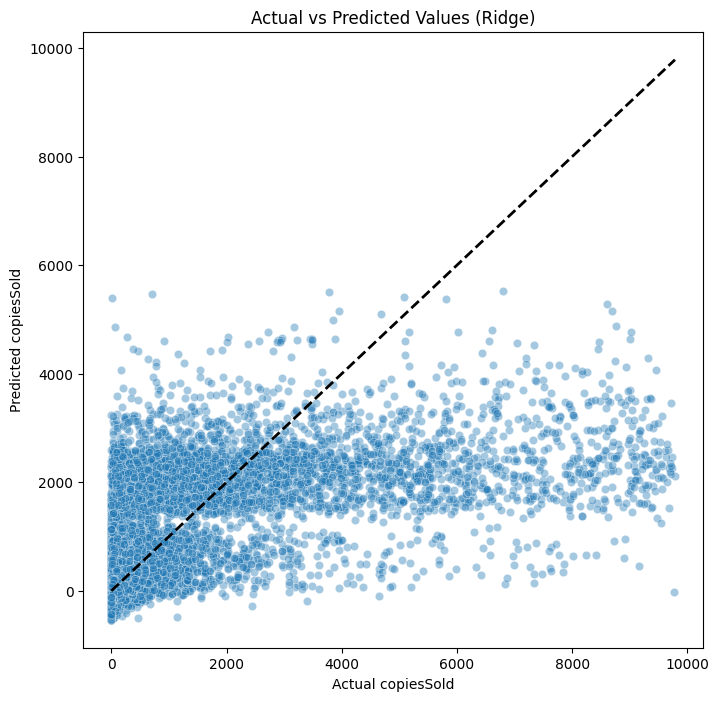

Random Forest Train Time: 17.78 sec
Random Forest Test Time: 0.49 sec

Random Forest Test MSE: 2567011.782 (2.567012e+06)
Random Forest Test R2 : 0.33189977869539034



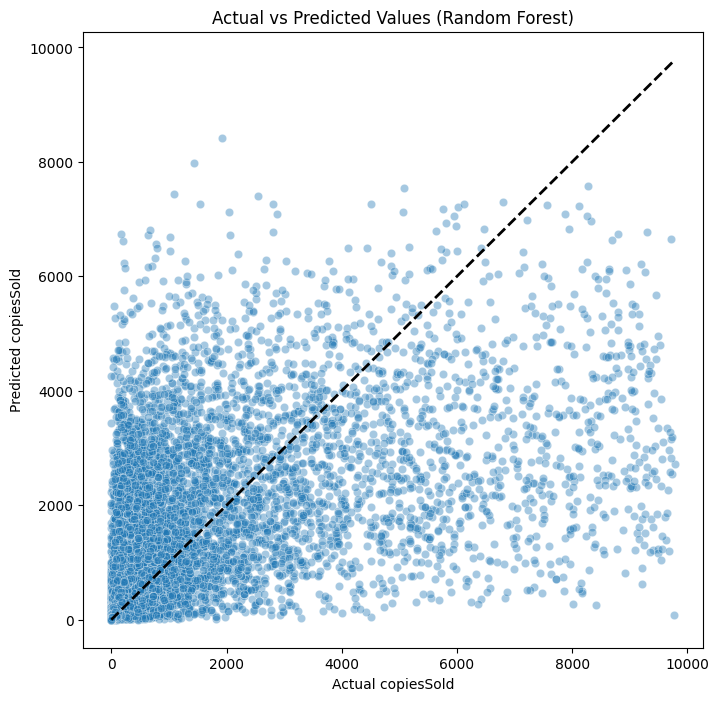

Gradient Boosting Train Time: 3.63 sec
Gradient Boosting Test Time: 0.05 sec

Gradient Boosting Test MSE: 2300963.695 (2.300964e+06)
Gradient Boosting Test R2 : 0.4011424627170427



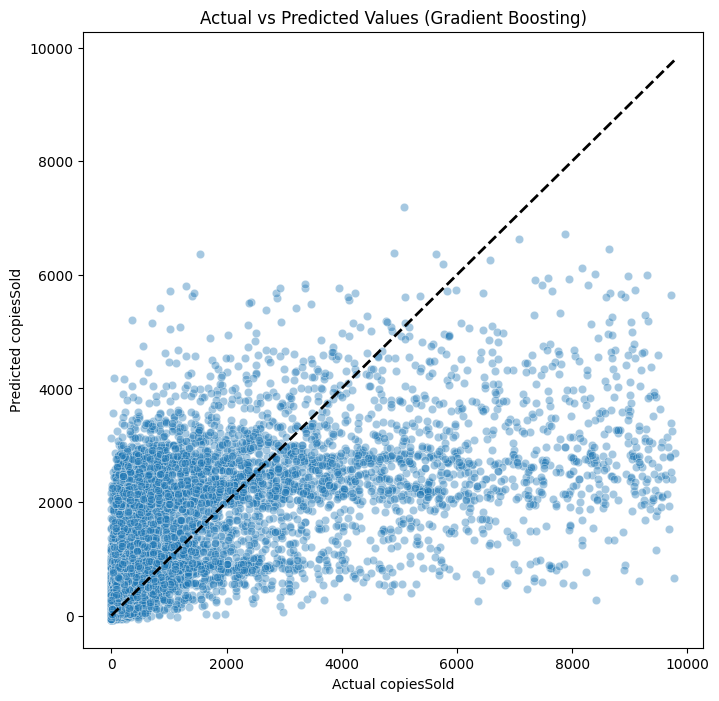

Polynomial Regression (Deg: 2) Train Time: 0.51 sec
Polynomial Regression (Deg: 2) Test Time: 0.07 sec

Polynomial Regression (Deg: 2) Test MSE: 2558724.457 (2.558724e+06)
Polynomial Regression (Deg: 2) Test R2 : 0.3340566695129258



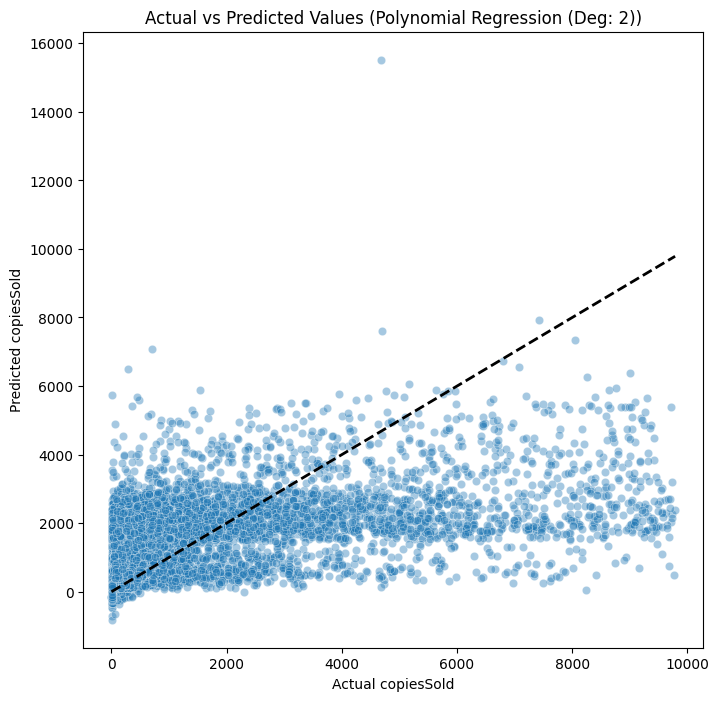

In [ ]:
wrapped_pipelines = []
for model_name, pipeline in tuned_pipeline:
    wrapped_model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    # mse_scores = cross_val_score(wrapped_model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    # r2_scores = cross_val_score(wrapped_model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)

    start_time_train = time.time()
    wrapped_model.fit(X_train, y_train)
    end_time_train = time.time()

    start_time_test = time.time()
    y_pred = wrapped_model.predict(X_test)
    end_time_test = time.time()

    # mse_val = mean(abs(mse_scores))
    mse_test = mean_squared_error(y_test, y_pred)

    print(f"{model_name} Train Time: {end_time_train - start_time_train:.2f} sec")
    print(f"{model_name} Test Time: {end_time_test - start_time_test:.2f} sec")
    print()

    # print(f"{model_name} Val MSE : {mse_val:.3f} ({mse_val:e})")
    # print(f"{model_name} Val R2  : {mean(r2_scores)}")
    print(f"{model_name} Test MSE: {mse_test:.3f} ({mse_test:e})")
    print(f"{model_name} Test R2 : {r2_score(y_test, y_pred)}")

    if param_grids.get(model_name):
        print(f"{model_name} Best Params: {wrapped_model.regressor_.best_params_}")

    print()

    wrapped_pipelines.append((model_name, wrapped_model))

    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2)
    plt.xlabel('Actual copiesSold')
    plt.ylabel('Predicted copiesSold')
    plt.title(f'Actual vs Predicted Values ({model_name})')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dump pipeline and encoders
blob = {
  'encoders': {
    'encoder_genres': encoder_genres,
    'encoder_supported_platforms': encoder_supported_platforms,
    'encoder_publisher_class': encoder_publisher_class,
  },
  'models': wrapped_pipelines,
}

with open('/content/drive/My Drive/ml_ms1.pkl', 'wb') as f:
    pickle.dump(blob, f)
    print("pickle yum yum!")

pickle yum yum!
